# Определение критериев успешности видео игр

Интернет-магазин «Стримчик» продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

## Постановка задачи

**Цель проекта** - выявить закономерности, определяющие успешность игры с точки зрения продаж.

Для этого необходимо:
1. Загрузить и проанализировать таблицу games.csv. Сформулировать перечень найденных ошибок в данных.
2. Провести предобработку данных: исправить ошибки, проанализировать пропуски, изменить типы данных. Добавить расчёты:
    - суммарные продажи по регионам.
3. Провести исследовательский анализ данных. Определить:
    - сколько игр выпускалось в разные годы;
    - как менялись продажи по платформам;
    - как влияют на продажи отзывы пользователей и критиков;
    - какие жанры наиболее прибыльны.
4. Проанализировать поведение пользователей. Определить для разных регионов:
    - самые популярные платформы;
    - самые популярные жанры;
    - влияние рейтинга ESRB на продажи.
5. Проверить гипотезы:
    - средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
    - средние пользовательские рейтинги жанров Action и Sports разные.
6. Сформулировать общий вывод.

Подключим соответствующие библиотеки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy import stats as st

**Описание данных**

- *Name* — название игры
- *Platform* — платформа
- *Year_of_Release* — год выпуска
- *Genre* — жанр игры
- *NA_sales* — продажи в Северной Америке (миллионы проданных копий)
- *EU_sales* — продажи в Европе (миллионы проданных копий)
- *JP_sales* — продажи в Японии (миллионы проданных копий)
- *Other_sales* — продажи в других странах (миллионы проданных копий)
- *Critic_Score* — оценка критиков (максимум 100)
- *User_Score* — оценка пользователей (максимум 10)
- *Rating* — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Данные за 2016 год могут быть неполными.

## Изучение данных

### Изучение общей информации

Загрузим данные и преобразуем названия столбцов: из описания видно, что они в разном регистре.

In [2]:
games = pd.read_csv('datasets/games.csv')
games.columns = games.columns.str.lower()

Посмотрим на случайные десять строк и информацию о таблице games в целом.

In [3]:
games.sample(n=10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
2460,ATV Quad Power Racing 2,PS2,2003.0,Racing,0.41,0.32,0.00,0.11,68.0,tbd,E
710,Onimusha 2: Samurai's Destiny,PS2,2002.0,Adventure,0.62,0.44,1.06,0.13,84.0,9,M
2173,Driver: San Francisco,PS3,2011.0,Racing,0.24,0.52,0.01,0.18,79.0,7.7,T
4720,Armored Core 2: Another Age,PS2,2001.0,Simulation,0.11,0.08,0.19,0.03,75.0,8.8,T
13740,Lionel Trains: On Track,DS,2006.0,Action,0.04,0.00,0.00,0.00,47.0,tbd,E
3119,Tiger Woods PGA Tour 10,X360,2009.0,Sports,0.39,0.20,0.00,0.06,80.0,6.9,E
6785,Army Men: Sarge's Heroes 2,PS,2000.0,Shooter,0.14,0.09,0.00,0.02,48.0,7.3,T
15135,Luxor: The Wrath of Set,PSP,2006.0,Puzzle,0.02,0.00,0.00,0.00,60.0,tbd,E
9019,Sengoku Musou 3 Empires,PS3,2011.0,Action,0.00,0.00,0.14,0.00,NaN,NaN,NaN
1243,Dead Space 2,X360,2011.0,Shooter,0.94,0.44,0.00,0.13,90.0,8.6,M


In [4]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16446 non-null float64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Особенности таблицы:
1. Столбцы, содержащие пропуски:
    - name
    - year_of_release
    - genre
    - critic_score
    - user_score
    - rating
2. Столбцы platform, genre и rating по своему смыслу содержат ограниченное небольшое количество вариантов значений. Тип можно преобразовать в category.
3. Столбец year_of_release содержит год - нужно преобразовать тип в datetime.
4. Столбцы na_sales, eu_sales, jp_sales и other_sales содержат информацию о количестве проданных копий в миллионах. Значения столбцов с двумя знаками после запятой. Можно записать данные в тысячах копий и преобразовать тип столбцов в int.
5. Столбец critic_score содержит оценку критиков по 100-балльной шкале. Чтобы было удобнее сопоставлять эти оценки с оценками пользователей, лучше перевести значения в 10-балльную шкалу.
6. Столбец user_score должен содержать числовые значения, но тип данных определился как object. Среди значений есть строка "tbd".

In [5]:
print('Количество повторяющихся строк:', games.duplicated().sum())

Количество повторяющихся строк: 0


Полных дубликатов нет. Нужно проверить, не оказалось ли для одной и той же игры несколько разных строк.

In [6]:
print('Количество игр на одной платформе, для которых есть дополнительные строки в таблице:', games[games[['name','platform']].duplicated()].shape[0])

Количество игр на одной платформе, для которых есть дополнительные строки в таблице: 5


**Вывод**
1. В таблице есть пропуски. 
2. Значения столбцов можно отредактировать, а типы данных преобразовать в более подходящие. 
3. Дубликатов нет. Но для пяти игр есть данные в разных строках таблицы - это нужно проверить.

### Изучение значений столбцов

Столбец Name содержит названия различных игр. Проверим, нет ли повторов с учётом регистра записи названия.

In [7]:
print('Количество игр в таблице:', len(games['name'].unique()))
print('Количество игр, если записать всё в одном регистре:', len(games['name'].str.lower().unique()))

Количество игр в таблице: 11560
Количество игр, если записать всё в одном регистре: 11560


С регистром записи названий игр в таблице проблем нет.

Посмотрим на варианты значений категориальных столбцов.

In [8]:
print('Варианты значений столбца platform:', games['platform'].sort_values().unique())
print()
print('Варианты значений столбца genre:', games['genre'].unique())
print()
print('Варианты значений столбца rating:', games['rating'].unique())

Варианты значений столбца platform: ['2600' '3DO' '3DS' 'DC' 'DS' 'GB' 'GBA' 'GC' 'GEN' 'GG' 'N64' 'NES' 'NG'
 'PC' 'PCFX' 'PS' 'PS2' 'PS3' 'PS4' 'PSP' 'PSV' 'SAT' 'SCD' 'SNES' 'TG16'
 'WS' 'Wii' 'WiiU' 'X360' 'XB' 'XOne']

Варианты значений столбца genre: ['Sports' 'Platform' 'Racing' 'Role-Playing' 'Puzzle' 'Misc' 'Shooter'
 'Simulation' 'Action' 'Fighting' 'Adventure' 'Strategy' nan]

Варианты значений столбца rating: ['E' nan 'M' 'T' 'E10+' 'K-A' 'AO' 'EC' 'RP']


В столбце rating значение "K-A" (Kids to Adults) - это устаревший вариант категории "E" (Everyone). Значение "RP" (Rating Pending) используется в рекламе до получения официального рейтинга. Если игра вышла в продажу, у неё должен быть настоящий рейтинг, а не "RP".

Проверим минимальные и максимальные значения числовых столбцов, включая год.

In [9]:
games[['year_of_release','na_sales','eu_sales','jp_sales','other_sales','critic_score']].describe().loc[['min','max']]

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score
min,1980.0,0.00,0.00,0.00,0.00,13.0
max,2016.0,41.36,28.96,10.22,10.57,98.0


Отрицательных значений или неожиданно больших значений нет. Максимальная оценка критиков вписывается в рамки 100-балльной шкалы.

Среди значений столбца user_score есть "tbd" - to be determined. Остальные заполненные значения должны быть числовыми. Посмотрим на минимум и максимум.

In [10]:
games[games['user_score'] != 'tbd'][['user_score']].astype('float').describe().loc[['min','max']]

,user_score
min,0.0
max,9.7


Числовые значения вписываются в 10-балльную шкалу оценок.

**Вывод**
1. В столбце rating значение "K-A" нужно преобразовать в "E". Значение "RP" нужно изменить на актуальное.
2. В столбце user_score есть нечисловое значение "tbd".

### Вывод

В таблице с данными есть проблемы, которые нужно решить, прежде чем переходить к анализу:
1. Необходимо преобразовать значения столбцов:
    - na_sales, eu_sales, jp_sales, other_sales: умножить значения на 1000;
    - critic_score: разделить значения на 10;
    - user_score: определить, что делать со значением "tbd";
    - rating: значение "K-A" заменить на "E", определить, что делать со значением "RP".
2. У пяти игр в таблице есть более одной строки с данными.
3. Необходимо преобразовать типы данных:
    - object в category:
        - platform
        - genre
        - rating
    - object в float:
        - user_score
    - float в datetime:
        - year_of_release
    - float в int:
        - na_sales
        - eu_sales
        - jp_sales
        - other_sales
4. Необходимо проанализировать и заполнить пропуски в столбцах:
    - name
    - year_of_release
    - genre
    - critic_score
    - user_score
    - rating

## Подготовка данных

### Исправление значений

Значения столбцов na_sales, eu_sales, jp_sales и other_sales даны в миллионах проданных копий. Представим их в тысячах проданных копий, для чего умножим все значения на 1000.

In [11]:
games[['na_sales','eu_sales','jp_sales','other_sales']] *= 1000

Чтобы оценки пользователей и критиков были в одной шкале, разделим оценки критиков на 10 - тогда они будут представлены в 10-балльной системе. (Можно было бы перевести оба столбца в 100-балльную систему и изменить тип на int. Но в таблице много пропущенных значений с оценками, а NaN - float. Т.е. без полного избавления от пропусков не удастся преобразовать тип в int. При этом 10-балльная система оценок игр привычнее.)

In [12]:
games['critic_score'] /= 10

Значение "tbd" (to be determined) в столбце user_score означает, что на момент создания таблицы оценка не была определена. Возможно, слишком малое количество пользователей оценило игру, поэтому нельзя было сделать окончательный вывод о пользовательской оценке. В данном случае значение "tbd" равносильно NaN. 

In [13]:
games.loc[games['user_score'] == 'tbd','user_score'] = np.nan

В столбце rating заменим значение "K-A" на "E".

In [14]:
games['rating'] = games['rating'].where(games['rating'] != 'K-A', 'E')

Посмотрим на игры категории "RP".

In [15]:
games[games['rating'] == 'RP']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
13672,Clockwork Empires,PC,NaN,Strategy,0.0,40.0,0.0,0.0,5.8,3.8,RP
14270,Supreme Ruler: Cold War,PC,2011.0,Strategy,0.0,30.0,0.0,10.0,6.3,6.8,RP
16180,WRC: FIA World Rally Championship,PC,NaN,Racing,0.0,10.0,0.0,0.0,6.5,NaN,RP


Установим для этих трёх игр актуальный рейтинг.

In [16]:
games.loc[(games['name'] == 'Clockwork Empires') & (games['rating'] == 'RP'),'rating'] = 'E10+'
games.loc[(games['name'] == 'Supreme Ruler: Cold War') & (games['rating'] == 'RP'),'rating'] = 'E10+'
games.loc[(games['name'] == 'WRC: FIA World Rally Championship') & (games['rating'] == 'RP'),'rating'] = 'E'

Посмотрим на 5 игр, для которых есть повторы.

In [17]:
games[games[['name','platform']].duplicated()][['name','platform']]

,name,platform
1591,Need for Speed: Most Wanted,X360
4127,Sonic the Hedgehog,PS3
11715,Need for Speed: Most Wanted,PC
14244,NaN,GEN
16230,Madden NFL 13,PS3


На самом деле это три игры и одна с неизвестным названием.

In [18]:
games[games['name'] == 'Need for Speed: Most Wanted'].sort_values('platform')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
6410,Need for Speed: Most Wanted,DS,2005.0,Racing,240.0,10.0,0.0,20.0,4.5,6.1,E
6473,Need for Speed: Most Wanted,GBA,2005.0,Racing,190.0,70.0,0.0,0.0,NaN,8.3,E
3581,Need for Speed: Most Wanted,GC,2005.0,Racing,430.0,110.0,0.0,20.0,8.0,9.1,T
5972,Need for Speed: Most Wanted,PC,2005.0,Racing,20.0,230.0,0.0,40.0,8.2,8.5,T
11715,Need for Speed: Most Wanted,PC,2012.0,Racing,0.0,60.0,0.0,20.0,8.2,8.5,T
253,Need for Speed: Most Wanted,PS2,2005.0,Racing,2030.0,1790.0,80.0,470.0,8.2,9.1,T
523,Need for Speed: Most Wanted,PS3,2012.0,Racing,710.0,1460.0,60.0,580.0,NaN,NaN,NaN
2048,Need for Speed: Most Wanted,PSV,2012.0,Racing,330.0,450.0,10.0,220.0,NaN,NaN,NaN
6273,Need for Speed: Most Wanted,WiiU,2013.0,Racing,130.0,120.0,0.0,20.0,NaN,NaN,NaN
1190,Need for Speed: Most Wanted,X360,2012.0,Racing,620.0,780.0,10.0,150.0,8.3,8.5,T


Повторы игры Need for Speed: Most Wanted - это релизы разных лет, а не дубликаты.

In [19]:
games[(games['name'] == 'Sonic the Hedgehog') | (games['name'] == 'Madden NFL 13')].sort_values(['name','platform'])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012.0,Sports,2110.0,220.0,0.0,230.0,8.3,5.5,E
16230,Madden NFL 13,PS3,2012.0,Sports,0.0,10.0,0.0,0.0,8.3,5.5,E
5887,Madden NFL 13,PSV,2012.0,Sports,280.0,0.0,0.0,20.0,6.3,7.3,E
3986,Madden NFL 13,Wii,2012.0,Sports,470.0,0.0,0.0,30.0,NaN,7.3,E
7066,Madden NFL 13,WiiU,2012.0,Sports,210.0,0.0,0.0,20.0,7.5,6.7,E
507,Madden NFL 13,X360,2012.0,Sports,2530.0,150.0,0.0,170.0,8.1,5.8,E
257,Sonic the Hedgehog,GEN,1991.0,Platform,3030.0,910.0,260.0,130.0,NaN,NaN,NaN
1745,Sonic the Hedgehog,PS3,2006.0,Platform,410.0,60.0,40.0,660.0,4.3,4.1,E10+
4127,Sonic the Hedgehog,PS3,NaN,Platform,0.0,480.0,0.0,0.0,4.3,4.1,E10+
1996,Sonic the Hedgehog,X360,2006.0,Platform,440.0,480.0,0.0,110.0,4.6,4.4,E10+


У игр Madden NFL 13 и Sonic the Hedgehog на PS3 данные по продажам разные. Видимо, они были собраны из разных источников. Одна строка содержит только продажи в Европе, другая - по всем странам. При этом количество проданных копий в Европе в двух строчках разные. Объединим эти строки в одну. Будем считать, что данные по Европе в разных источниках не пересекались между собой.

In [20]:
games.loc[(games['name'] == 'Madden NFL 13') & (games['platform'] == 'PS3'),'na_sales'] = (
    games.loc[(games['name'] == 'Madden NFL 13') & (games['platform'] == 'PS3'),'na_sales']
    .sum()
)
games.loc[(games['name'] == 'Madden NFL 13') & (games['platform'] == 'PS3'),'eu_sales'] = (
    games.loc[(games['name'] == 'Madden NFL 13') & (games['platform'] == 'PS3'),'eu_sales']
    .sum()
)
games.loc[(games['name'] == 'Madden NFL 13') & (games['platform'] == 'PS3'),'jp_sales'] = (
    games.loc[(games['name'] == 'Madden NFL 13') & (games['platform'] == 'PS3'),'jp_sales']
    .sum()
)
games.loc[(games['name'] == 'Madden NFL 13') & (games['platform'] == 'PS3'),'other_sales'] = (
    games.loc[(games['name'] == 'Madden NFL 13') & (games['platform'] == 'PS3'),'other_sales']
    .sum()
)

games.loc[(games['name'] == 'Sonic the Hedgehog') & (games['platform'] == 'PS3'),'na_sales'] = (
    games.loc[(games['name'] == 'Sonic the Hedgehog') & (games['platform'] == 'PS3'),'na_sales'] 
    .sum()
)
games.loc[(games['name'] == 'Sonic the Hedgehog') & (games['platform'] == 'PS3'),'eu_sales'] = (
    games.loc[(games['name'] == 'Sonic the Hedgehog') & (games['platform'] == 'PS3'),'eu_sales']
    .sum()
)
games.loc[(games['name'] == 'Sonic the Hedgehog') & (games['platform'] == 'PS3'),'jp_sales'] = (
    games.loc[(games['name'] == 'Sonic the Hedgehog') & (games['platform'] == 'PS3'),'jp_sales']
    .sum()
)
games.loc[(games['name'] == 'Sonic the Hedgehog') & (games['platform'] == 'PS3'),'other_sales'] = (
    games.loc[(games['name'] == 'Sonic the Hedgehog') & (games['platform'] == 'PS3'),'other_sales']
    .sum()
)
games.loc[(games['name'] == 'Sonic the Hedgehog') & (games['platform'] == 'PS3'),'year_of_release'] = 2006

games = games.drop_duplicates().reset_index(drop=True)

Строки с пропущенными названиями рассмотрим в разделе 3.3.

**Вывод**
1. Значения столбцов na_sales, eu_sales, jp_sales, other_sales представлены в тысячах проданных копий.
2. Значения оценок критиков в столбце critic_score переведены в 10-балльную шкалу.
3. Значение "tbd" в столбце user_score удалено.
4. Значение "K-A" столбца rating заменино на "E". Значение "RP" заменено на актуальное.
5. Дубликаты отработаны.

### Замена типов данных

Значения столбцов na_sales, eu_sales, jp_sales и other_sales выражены в тысячах копий. Теоретически после запятой могут быть три знака осмысленных значений. Но если там нули, тип столбца можно преобразовать в int.

In [21]:
def sales_to_int (column_name):
    if (abs(games[column_name] - np.round(games[column_name])) >= 0.001).sum() == 0: 
        #Количество строк со значениями после запятой >= 0.001
        
        games[column_name] = games[column_name].astype('int')
        
sales_to_int('na_sales')
sales_to_int('eu_sales')
sales_to_int('jp_sales')
sales_to_int('other_sales')

games[['na_sales','eu_sales','jp_sales','other_sales']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 4 columns):
na_sales       16713 non-null int64
eu_sales       16713 non-null int64
jp_sales       16713 non-null int64
other_sales    16713 non-null int64
dtypes: int64(4)
memory usage: 522.4 KB


Изменим тип user_score на числовой.

In [22]:
games['user_score'] = games['user_score'].astype('float')

Тип столбцов platform, genre и rating преобразуем в category. Чтобы в дальнейшем анализировать и неизвестные значения рейтинга, заполним пропуски в столбце rating на "Unknown".

In [23]:
games['platform'] = games['platform'].astype('category')
games['genre'] = games['genre'].astype('category')

games['rating'] = games['rating'].fillna('Unknown')
games['rating'] = games['rating'].astype('category')

Год в year_of_release нужно представить как год, а не число. В формате datetime добавятся значения даты и месяца, которые нам не нужны. Поэтому достаточно сделать год целым числом для адекватного представления данных. Но со значениями NaN сделать столбец целочисленным невозможно. Поэтому заполним пропуски значением 0 и преобразуем формат.

In [24]:
games['year_of_release'] = games['year_of_release'].fillna(0)
games['year_of_release'] = games['year_of_release'].astype('int')
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 11 columns):
name               16711 non-null object
platform           16713 non-null category
year_of_release    16713 non-null int64
genre              16711 non-null category
na_sales           16713 non-null int64
eu_sales           16713 non-null int64
jp_sales           16713 non-null int64
other_sales        16713 non-null int64
critic_score       8135 non-null float64
user_score         7588 non-null float64
rating             16713 non-null category
dtypes: category(3), float64(2), int64(5), object(1)
memory usage: 1.1+ MB


**Вывод**

Типы данных преобразованы:
1. Столбцы na_sales, eu_sales, jp_sales, other_sales в int.
2. Столбец user_score - во float.
3. Столбцы platform, genre и rating - в category. Пропущенные значения столбца rating заполнены словом "Unknown".
4. Столбец year_of_release представлен как int, чтобы сохранить только год и не добавлять несуществующие день и месяц. Значения NaN заменены на 0.

### Обработка пропусков

Наименование и жанр не заполнены в двух строчках - возможно, это одни и те же две строчки. Посмотрим на них.

In [25]:
games[games['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1780,530,0,80,NaN,NaN,Unknown
14243,NaN,GEN,1993,NaN,0,0,30,0,NaN,NaN,Unknown


Действительно, наименование и жанр не заполнены в одних и тех же строках. Это игры 1993 года для платформы Sega Genesis. Причём у одной из этих игр есть данные о продажах в Японии, а у другой - во всех остальных странах. Других данных по этим играм нет. 

Посмотрим, какой процент игр для этой платформы и для 1993 года составляют две неизвестные строчки.

In [26]:
print('Доля игр с неизвестным названием для платформы Sega Genesis: {:.1%}'.format(2 / games[games['platform'] == 'GEN'].shape[0]))
print('Доля игр с неизвестным названием для 1993 года: {:.1%}'.format(2 / games[games['year_of_release'] == 1993].shape[0]))

Доля игр с неизвестным названием для платформы Sega Genesis: 6.9%
Доля игр с неизвестным названием для 1993 года: 3.2%


Для платформы Sega Genesis и для 1993 года не очень много данных, поэтому продажи игр с неизвестным названием всё равно важны для анализа. Для этих двух строк кроме года и платформы других данных нет и восстановить их не представляется возможным, а данные по продажам взаимно дополняют друг друга: одна игра продавалась только в Япони, а другая - во всех остальных странах. Без названия невозможно сказать точно, это две разные игры или одна и та же, но в двух релизах: для внутреннего японского рынка и экспортная. Поэтому эти две строки можно объединить в одну неизвестную игру 1993 года для Sega Genesis с соответствующими продажами по регионам. Данные ценны именно для анализа зависимости продаж от года и платформы, поэтому можно объединить две неизвестные игры в одну. При этом в учёте общего количества игр лучше не посчитать одну неизвестную игру, чем случайно посчитать одну игру дважды. 

In [27]:
games.loc[games['name'].isna(),'na_sales'] = games.loc[games['name'].isna(),'na_sales'].sum()
games.loc[games['name'].isna(),'eu_sales'] = games.loc[games['name'].isna(),'eu_sales'].sum()
games.loc[games['name'].isna(),'jp_sales'] = games.loc[games['name'].isna(),'jp_sales'].sum()
games.loc[games['name'].isna(),'other_sales'] = games.loc[games['name'].isna(),'other_sales'].sum()

games = games.drop_duplicates().reset_index(drop=True)

У части игр не заполнен год выпуска. Эту информацию можно восстановить по названию игры и платформе, для которой она выпускалась. (Некоторые игры могли выходить в разное время на разных платформах.) Но для 268 игр провести такой поиск сложно.

Пропущенные значения оценок пользователей и критиков нельзя восстановить, пользуясь только предложенной таблицей, - это исказит данные. Для одной и той же игры, выпущенной на разных платформах, оценки могут отличаться. Если заполнить пропуски средними оценками по той же игре, это исказит разницу в оценках по платформам.

Рассмотрим пропуски в столбце rating. Рейтинг ESRB появился в 1994 году. Возможно, у некоторых игр нет рейтинга, потому что они были выпущены раньше.

In [28]:
print('Самый поздний год выпуска игры без рейтинга ESRB: {:.0f}'.format(games[games['rating'].isna()]['year_of_release'].max()))

Самый поздний год выпуска игры без рейтинга ESRB: nan


Предположение не оправдалось. Рейтинг привязан к названию игры, году её выпуска, платформе - его можно восстановить, но не с помощью других данных из таблицы. Рейтинг одной и той же игры, выпущенной на разных платформах, может отличаться, как и некоторые особенности самих этих игр.

**Вывод**

Без дополнительной информации невозможно восстановить пропуски в столбцах name, year_of_release, genre, critic_score, user_score и rating. Эти данные связаны между собой для каждой конкретной игры, но не привязаны к информации о других играх. Удалять строки с пропущенными значениями нецелесообразно, потому что информация о продажах ценна, даже если игра описана не полностью.

### Добавление расчётов

Добавим в таблицу суммарные продажи по всем регионам.

In [29]:
games['total_sales'] = games[['na_sales','eu_sales','jp_sales','other_sales']].sum(axis=1)

**Вывод**

Расчёты добавлены.

### Вывод

Значения столбцов пересчитаны: число проданных копий теперь указано в тысячах штук, а оценки критиков представлены в 10-балльной шкале. Столбец с годом выпуска отражает год как целое число, пропущенные значения года заменены на 0. Значение "tbd" в столбце user_score удалено. Значения "K-A" и "RP" в столбце rating заменены на актуальные. Найдены и удалены дубликаты с сохранением информации о продажах. Пропущенные значения столбцов оставлены как есть, чтобы не искажать данные. В таблицу добавлен столбец total_sales с информацией о суммарных продажах.

Таблица приняла следующий вид:
- *name* — название игры
- *platform* — платформа
- *year_of_release* — год выпуска
- *genre* — жанр игры
- *na_sales* — продажи в Северной Америке (тысячи проданных копий)
- *eu_sales* — продажи в Европе (тысячи проданных копий)
- *jp_sales* — продажи в Японии (тысячи проданных копий)
- *other_sales* — продажи в других странах (тысячи проданных копий)
- *total_sales* — общие продажи по всему миру (тысячи проданных копий)
- *critic_score* — оценка критиков (максимум 10)
- *user_score* — оценка пользователей (максимум 10)
- *rating* — рейтинг от организации ESRB

## Исследовательский анализ данных

### Определение актуального периода

Посмотрим, как менялось количество выпускаемых игр по годам.

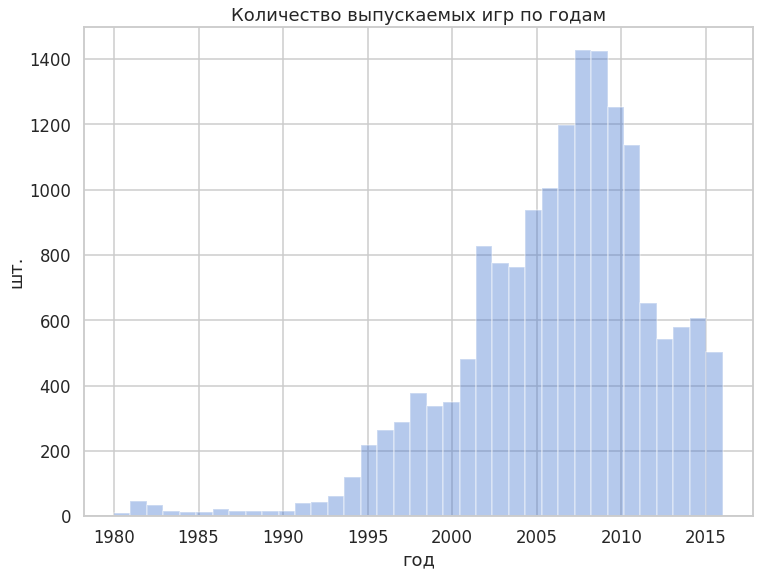

In [30]:
sns.set(context='talk', style='whitegrid', palette='muted')
plt.figure(figsize=(12, 9))

sns.distplot(
    games[games['year_of_release'] != 0]['year_of_release'],
    kde=False,
    hist=True,
    bins=37
)

plt.title('Количество выпускаемых игр по годам')
plt.xlabel('год')
plt.ylabel('шт.')
plt.show()

Количество выпускаемых игр стало быстро расти в 90-е годы, а после 2000 этот рост ускорился. Пик пришёлся на 2008-2009 годы, после чего количество выпускаемых игр начало снижаться. После 2011 года выпуски игр держатся ниже значения 2002 года. Можно отбросить левый хвост и рассматривать данные за последние (отностельно таблицы) 15 лет: с 2002 по 2016.

Посмотрим на количество игр для разных платформ. В первую очередь определим наиболее популярные платформы, ориентируясь на продажи.

In [31]:
top10_platforms = (
    games.pivot_table(index='platform', values='total_sales', aggfunc='sum')
    .reset_index()
    .sort_values(by='total_sales', ascending=False)['platform']
    .head(10)
)

print('Десять самых популярных платформ:', top10_platforms.values)

Десять самых популярных платформ: [PS2, X360, PS3, Wii, DS, PS, GBA, PS4, PSP, PC]
Categories (31, object): [2600, 3DO, 3DS, DC, ..., WiiU, X360, XB, XOne]


Построим кривую плотности частоты для каждой платформы в одних осях, чтобы сравнить.

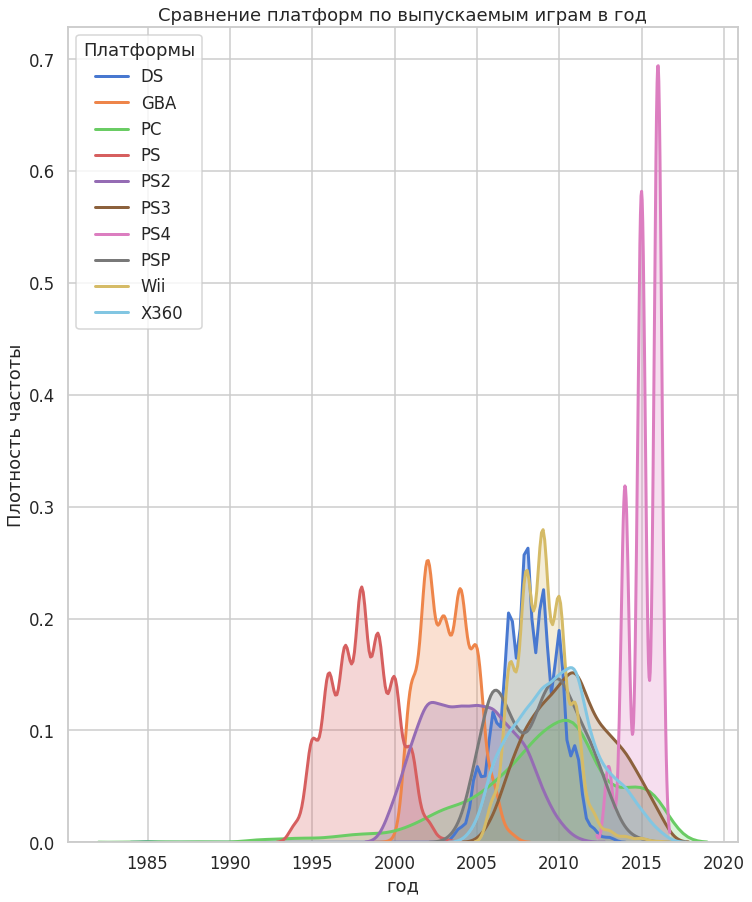

In [32]:
plt.figure(figsize=(12, 15))

for platform, data in games.groupby('platform'):
    if platform in top10_platforms.values:
        sns.distplot(
            data[data['year_of_release'] != 0]['year_of_release'],
            kde = True,
            hist = False,
            kde_kws = {'shade': True, 'linewidth':3},
            label = platform
        )

plt.legend(title = 'Платформы')      
plt.title('Сравнение платформ по выпускаемым играм в год')
plt.xlabel('год')
plt.ylabel('Плотность частоты')
plt.show()

На графике видно, как последовательно возникали, становились популярными, а затем исчезали последовательно платформы PS, GBA, затем DS и Wii - параллельно, а теперь в этом ряду следующей стоит PS4. У неё высокий пик, потому что она существует меньшее время по сравнению с остальными платформами. Параллельно с этим можно наблюдать, как сменяли друг друга PS2 и PS3 с X360. Этот ряд тоже логически продолжается PS4. Популярность PSP совпадает с периодом популярности большого количества платформ и приходится на тот период времени, когда игр вообще выпускалось больше всего. Популярность PC росла всё время и начала падать с появлением PS4. В целом за исключением PC платформы живут около 10 лет. И сейчас по всем параметрам актуальна PS4. С учётом времени жизни платформ нет смысла рассматривать данные старше пяти лет. 

Чтобы лучше рассмотреть параллельные линии существования разных платформ, разнесём их на соседние координаты.

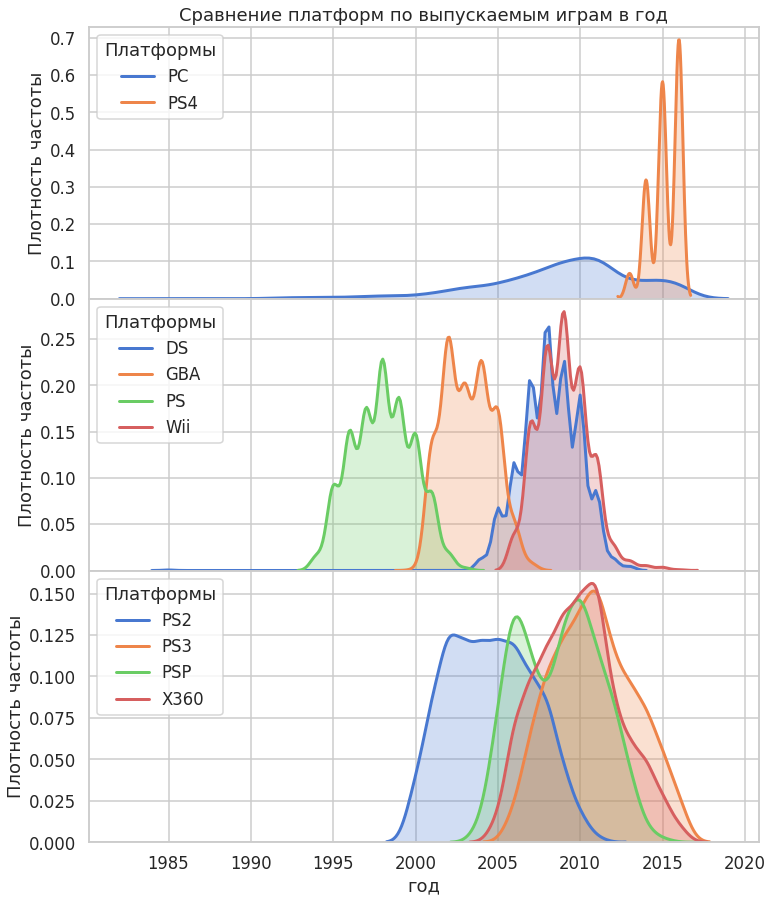

In [33]:
f, ax = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0})
f.set_figheight(15)
f.set_figwidth(12)

for platform, data in games.groupby('platform'):
    if platform in ['PC', 'PS4']:
        sns.distplot(
            data[data['year_of_release'] != 0]['year_of_release'],
            kde = True,
            hist = False,
            kde_kws = {'shade': True, 'linewidth':3},
            label = platform,
            ax = ax[0]
        )
    
    if platform in ['PS', 'Wii', 'DS', 'GBA']:
        sns.distplot(
            data[data['year_of_release'] != 0]['year_of_release'],
            kde = True,
            hist = False,
            kde_kws = {'shade': True, 'linewidth':3},
            label = platform,
            ax = ax[1]
        )
    
    if platform in ['PS2', 'PS3', 'PSP', 'X360']:
        sns.distplot(
            data[data['year_of_release'] != 0]['year_of_release'],
            kde = True,
            hist = False,
            kde_kws = {'shade': True, 'linewidth':3},
            label = platform,
            ax = ax[2]
        )

ax[0].set_title('Сравнение платформ по выпускаемым играм в год')

ax[0].set(xlabel='', ylabel='Плотность частоты')
ax[1].set(xlabel='', ylabel='Плотность частоты')
ax[2].set(xlabel='год', ylabel='Плотность частоты')

ax[0].legend(title = 'Платформы')
ax[1].legend(loc = 'upper left', title = 'Платформы')
ax[2].legend(title = 'Платформы')

plt.show()

Теперь особенно заметно, что популярность PSP привязана к популярности PS2 и PS3.

Кроме того, стало хорошо видно, что данные за 2010 и 2011 год содержат "хвосты" исчезающих с рынка платформ - они не нужны для анализа. Создадим таблицу с актуальными данными за 5 лет: с 2012 года по 2016.

In [34]:
actual_games = games[(games['year_of_release'] >= 2012) & (games['year_of_release'] <= 2016)]
actual_games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2885 entries, 16 to 16711
Data columns (total 12 columns):
name               2885 non-null object
platform           2885 non-null category
year_of_release    2885 non-null int64
genre              2885 non-null category
na_sales           2885 non-null int64
eu_sales           2885 non-null int64
jp_sales           2885 non-null int64
other_sales        2885 non-null int64
critic_score       1311 non-null float64
user_score         1530 non-null float64
rating             2885 non-null category
total_sales        2885 non-null int64
dtypes: category(3), float64(2), int64(6), object(1)
memory usage: 236.1+ KB


**Вывод**
1. По общему числу выпускаемых игр современным можно считать период с 2002 года, но время жизни платформ оказалось около 10 лет. Чтобы сфокуссироваться на актуальных платформах, для анализа был выбран период 5 лет: с 2012 года по 2016 включительно. 
2. Среди самых популярных платформ наиболее перспективной является PS4.

### Анализ продаж за актуальный период

Посмотрим, как менялось количество проданных игр на разных платформах за последние 5 лет.

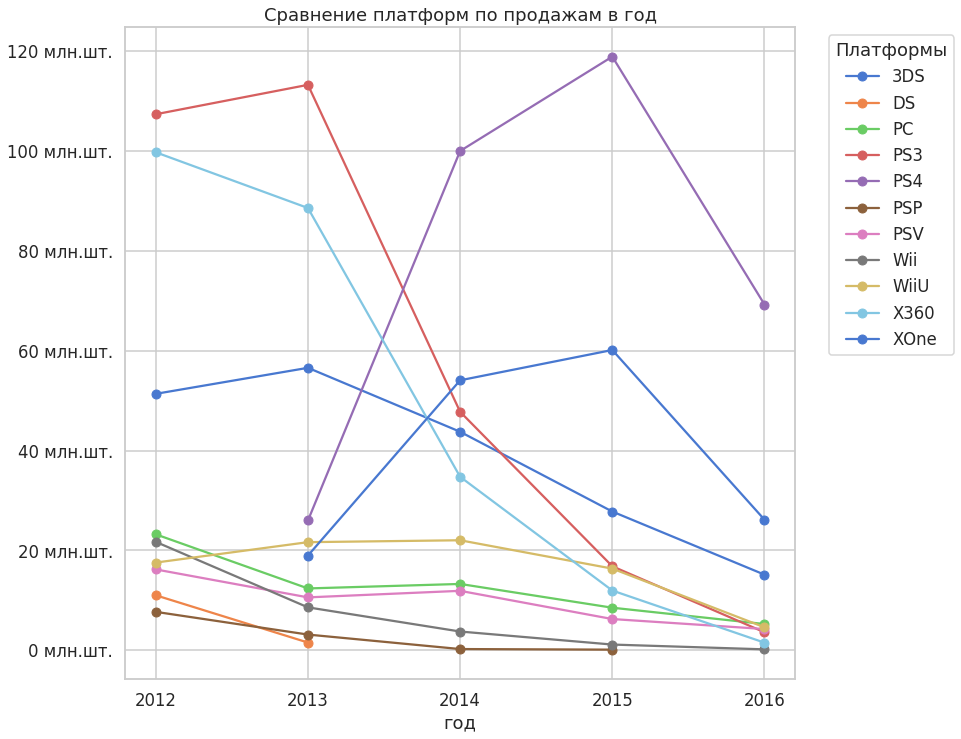

In [35]:
actual_games_score = (
    actual_games
    .pivot_table(index=['platform','year_of_release'], values='total_sales', aggfunc='sum')
    .reset_index()
)

f, ax = plt.subplots(1)
f.set_figheight(12)
f.set_figwidth(12)

top_actual_platforms = [] #Сохраним список платформ, для которых есть данные в таблице actual_games

for platform, data in actual_games_score.groupby('platform'):
    if data.shape[0] > 0:
        top_actual_platforms.append(platform)
        
        plt.plot(
            'year_of_release',
            'total_sales',
            data = data,
            linestyle = '-',
            marker = 'o',
            label = platform
        )

plt.legend(title = 'Платформы', loc = 'upper right', bbox_to_anchor=(1.25, 1))      
plt.title('Сравнение платформ по продажам в год')
plt.xlabel('год')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ylabels = ['{:.0f}'.format(x) + ' млн.шт.' for x in ax.get_yticks()/1000]
ax.set_yticklabels(ylabels)
plt.show()

Видно, что у большей части платформ продажи не поднимаются сильно выше 20 млн. шт. в год. Среди самых популярных платформ наблюдается смена поколений: на место PS3 и X360 приходят PS4 и XOne. Снижение продаж в последний год у набирающих популярность платформ можно объяснить тем, что данные за 2016 год в таблице неполные.

Для наглядности изобразим график продаж для пяти наиболее популярных платформ.

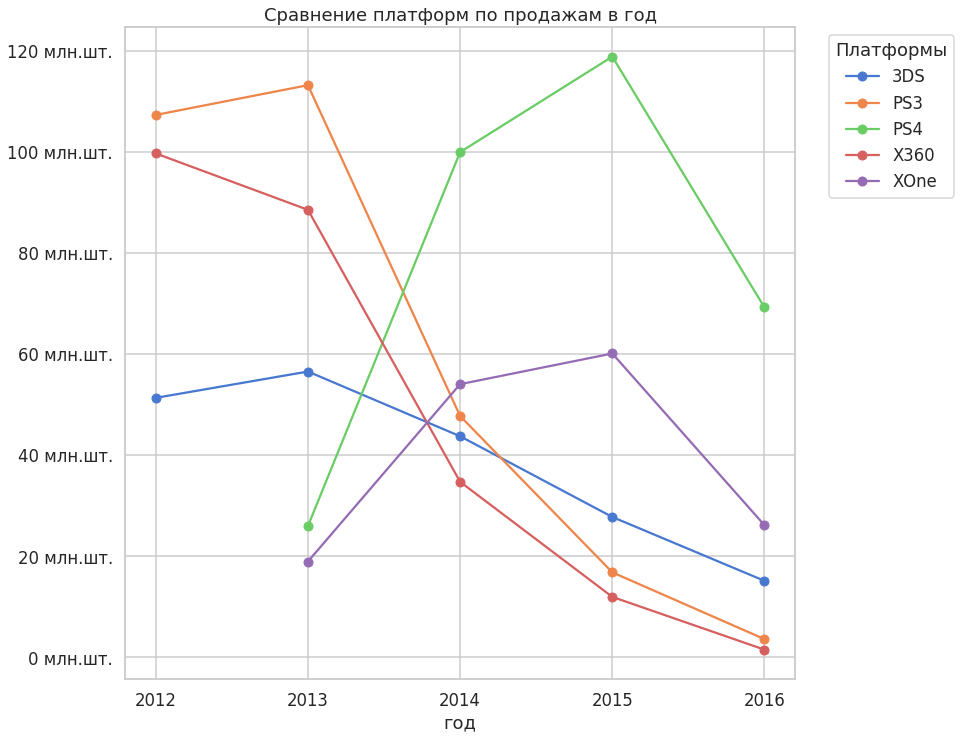

In [36]:
top5_actual_platforms = (
    actual_games_score.pivot_table(index='platform', values='total_sales', aggfunc='sum')
    .reset_index()
    .sort_values(by='total_sales', ascending=False)['platform']
    .head()
)

f, ax = plt.subplots(1)
f.set_figheight(12)
f.set_figwidth(12)

for platform, data in actual_games_score.groupby('platform'):
    if platform in top5_actual_platforms.values:
        plt.plot(
            'year_of_release',
            'total_sales',
            data = data,
            linestyle = '-',
            marker = 'o',
            label = platform
        )

plt.legend(title = 'Платформы', loc = 'upper right', bbox_to_anchor=(1.25, 1))      
plt.title('Сравнение платформ по продажам в год')
plt.xlabel('год')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ylabels = ['{:.0f}'.format(x) + ' млн.шт.' for x in ax.get_yticks()/1000]
ax.set_yticklabels(ylabels)
plt.show()

PS4 и XOne в отличие от остальных платформ показывали рост с 2013 по 2015 год. Кроме того, это молодые платформы, популярность которых продлится ещё несколько лет, если ориентироваться на средний период жизни предыдущих популярных платформ. Данные за 2016 год неполные - этим может объясняться спад на графике после 2015 года. Продажи на PS3, X360 и 3DS падают, но у последней, Nintendo, они остаются достаточно высокими. Можно считать перспективными три платформы: PS4, XOne и 3DS.

Посмотрим, сколько экземпляров одной игры обычно удаётся продать для каждой платформы.

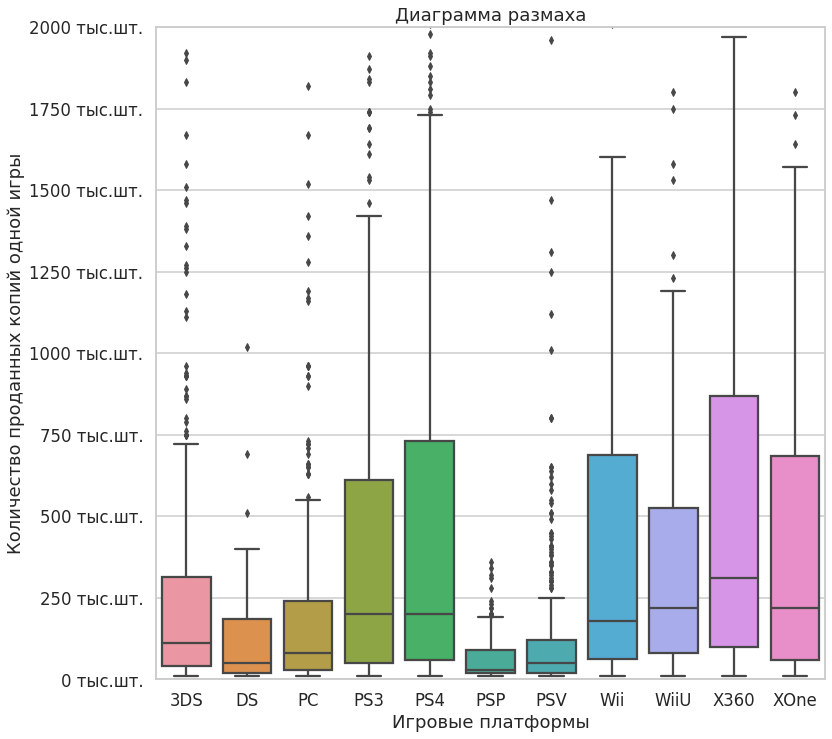

In [37]:
plt.figure(figsize=(12, 12))

ax = sns.boxplot(
    x = 'platform',
    y = 'total_sales',
    data = actual_games,
    order = top_actual_platforms
)

plt.ylim(0, 2000)
ylabels = ['{:.0f}'.format(x) + ' тыс.шт.' for x in ax.get_yticks()]
ax.set_yticklabels(ylabels)
plt.title('Диаграмма размаха')
plt.xlabel('Игровые платформы')
plt.ylabel('Количество проданных копий одной игры')
plt.show()

На диаграмме достаточно много выбросов - это продажи очень успешных игр, они есть у каждой платформы. Если судить по большей части игр, лучше всего продажи идут у трёх линеек-производителей: Play Station, Xbox и Nintendo. Медианные значения количества проданных копий игры для PS3 и PS4 одинаковые, тогда как XOne пока не обогнала X360. Лучше всего игры проодаются на Xbox. Продажи на Wii и WiiU сопоставимы с Play Station. Суммарные продажи у Nintendo на прошлом графике не были высоки, потому что жизненный цикл Wii подходит к концу (что видно на графике в разделе 4.1). Судя по всему, на Wii и WiiU уже не выпускается много игр, но игры всё равно хорошо продаются. В будущем можно обратить внимание на новую платформу от Nintendo, когда она появится на рынке. Сейчас можно выделить две перспективные платформы: PS4 и XOne. Продажи на PC существенно ниже, но в отличие от других игровых платформ время жизни PC несопоставимо выше. И не смотря на снижение количества продаваемых игр на PC, ещё рано говорить о том, что персональный компьютер потерял свою актуальность. 

Медианное значение количества продаваемых копий одной игры у XOne больше, чем у PS4, но при этом у PS4 длиннее правый (верхний) хвост. Это значит, что в целом на PS4 можно продавать больше копий одной игры, чем на XOne. Что подтверждается и предыдущим графиком суммарных продаж. Посмотрим, как влияют оценки пользователей и критиков на продажи игр на PS4.

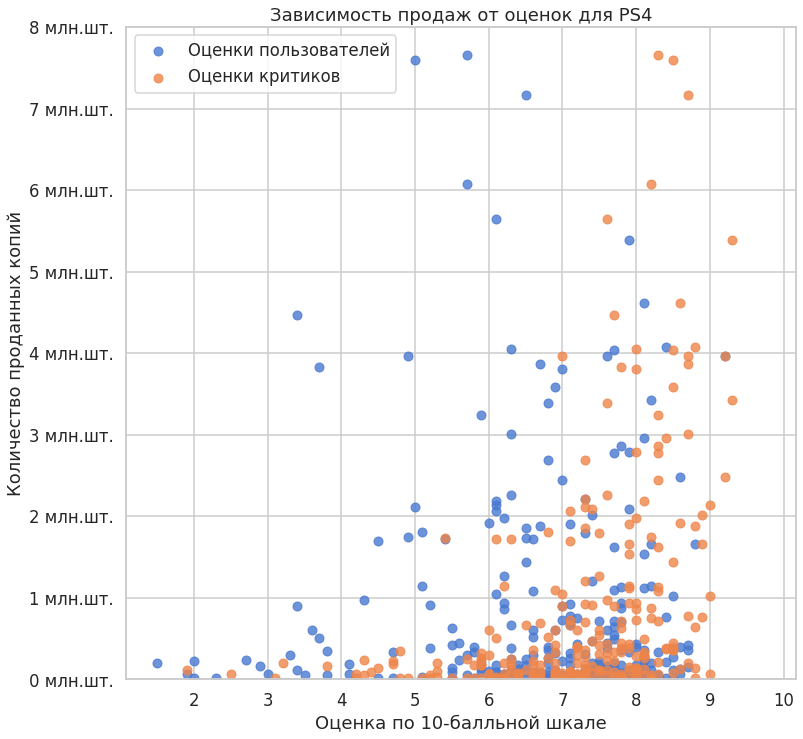

In [38]:
f, ax = plt.subplots(1)
f.set_figheight(12)
f.set_figwidth(12)


sns.regplot(
    x = actual_games[actual_games['platform'] == 'PS4']['user_score'],
    y = actual_games[actual_games['platform'] == 'PS4']['total_sales'],
    fit_reg = False,
    label = 'Оценки пользователей'
)
sns.regplot(
    x = actual_games[actual_games['platform'] == 'PS4']['critic_score'],
    y = actual_games[actual_games['platform'] == 'PS4']['total_sales'],
    fit_reg = False,
    label = 'Оценки критиков'
)

plt.ylim(0, 8000)
plt.legend()      
plt.title('Зависимость продаж от оценок для PS4')
plt.xlabel('Оценка по 10-балльной шкале')
plt.ylabel('Количество проданных копий')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ylabels = ['{:.0f}'.format(x) + ' млн.шт.' for x in ax.get_yticks() / 1000]
ax.set_yticklabels(ylabels)
plt.show()

На диаграмме рассеяния видно, что чем выше оценка критиков, тем лучше могут продаваться игры. Но прямой зависимости здесь нет: существуют игры с меньшими оценками, которые продаются существенно лучше других игр, с более высокими оценками. Оценки пользователей связаны с продажами в ешё меньшей степени: есть игры с низкими оценками пользователей, но при этом хорошо продающиеся. Построим матрицу корреляций и посмотрим, как связаны эти параметры между собой.

In [39]:
print('Матрица корреляций для оценок и продаж:')
actual_games[actual_games['platform'] == 'PS4'][['total_sales','user_score','critic_score']].corr()

Матрица корреляций для оценок и продаж:


,total_sales,user_score,critic_score
total_sales,1.000000,-0.031957,0.406568
user_score,-0.031957,1.000000,0.557654
critic_score,0.406568,0.557654,1.000000


Продажи не коррелируют с оценками пользователей, но имеют некоторую связь с оценками критиков. Можно сказать, если оценка критиков низкая, то игра будет продаваться плохо. Если оценка высокая, предсказать уровень продаж нельзя, он может принять любое значение. И этот вывод, скорее всего, будет работать для всех платформ. Посмотрим на диаграмму рассеяния без привязки к платформе.

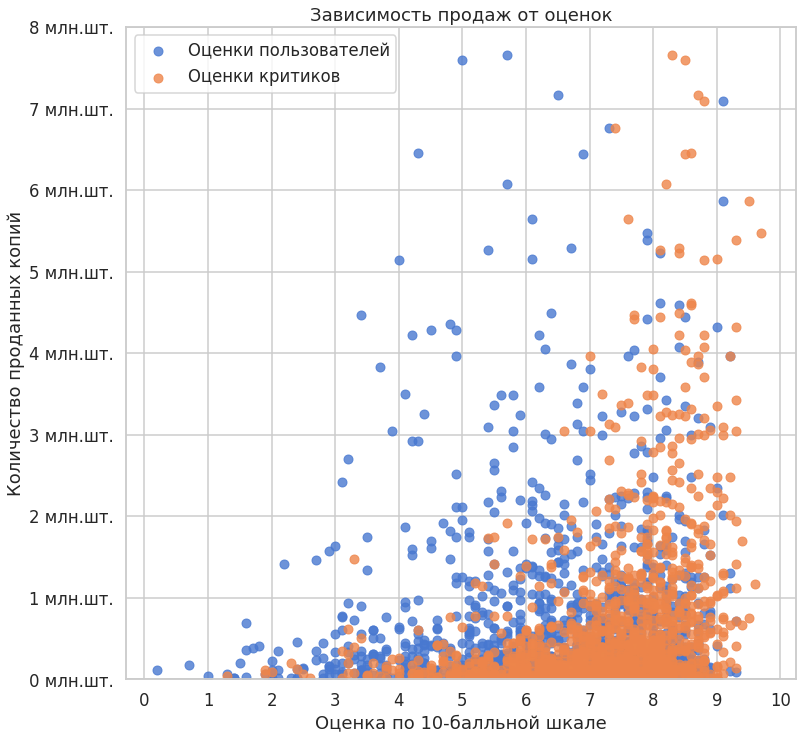

In [40]:
f, ax = plt.subplots(1)
f.set_figheight(12)
f.set_figwidth(12)


sns.regplot(
    x = actual_games['user_score'],
    y = actual_games['total_sales'],
    fit_reg = False,
    label = 'Оценки пользователей'
)
sns.regplot(
    x = actual_games['critic_score'],
    y = actual_games['total_sales'],
    fit_reg = False,
    label = 'Оценки критиков'
)

plt.ylim(0, 8000)
plt.legend()      
plt.title('Зависимость продаж от оценок')
plt.xlabel('Оценка по 10-балльной шкале')
plt.ylabel('Количество проданных копий')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ylabels = ['{:.0f}'.format(x) + ' млн.шт.' for x in ax.get_yticks() / 1000]
ax.set_yticklabels(ylabels)
plt.show()

Картина остаётся прежней. На продажи негативно влияют низкие оценки критиков.

Посмотрим, как на продажи влияют жанры.

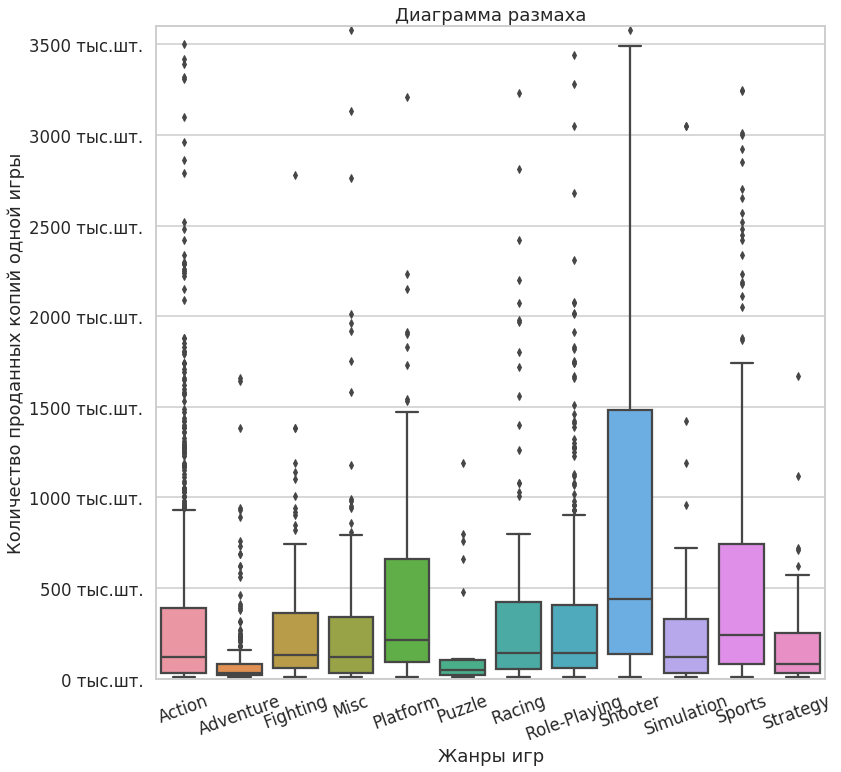

In [41]:
plt.figure(figsize=(12, 12))

ax = sns.boxplot(
    x = 'genre',
    y = 'total_sales',
    data = actual_games
)

plt.ylim(0, 3600)
ylabels = ['{:.0f}'.format(x) + ' тыс.шт.' for x in ax.get_yticks()]
ax.set_yticklabels(ylabels)
plt.title('Диаграмма размаха')
plt.ylabel('Количество проданных копий одной игры')
plt.xlabel('Жанры игр')
plt.xticks(rotation=20)
plt.show()

На общем фоне выделяются "шутеры" - они продаются лучше остальных игр. Следом идут спортивные игры и "платформеры". Хуже всего продаются головоломки и квесты. (Что печально.)

Посмотрим на суммарные продажи по жанрам.

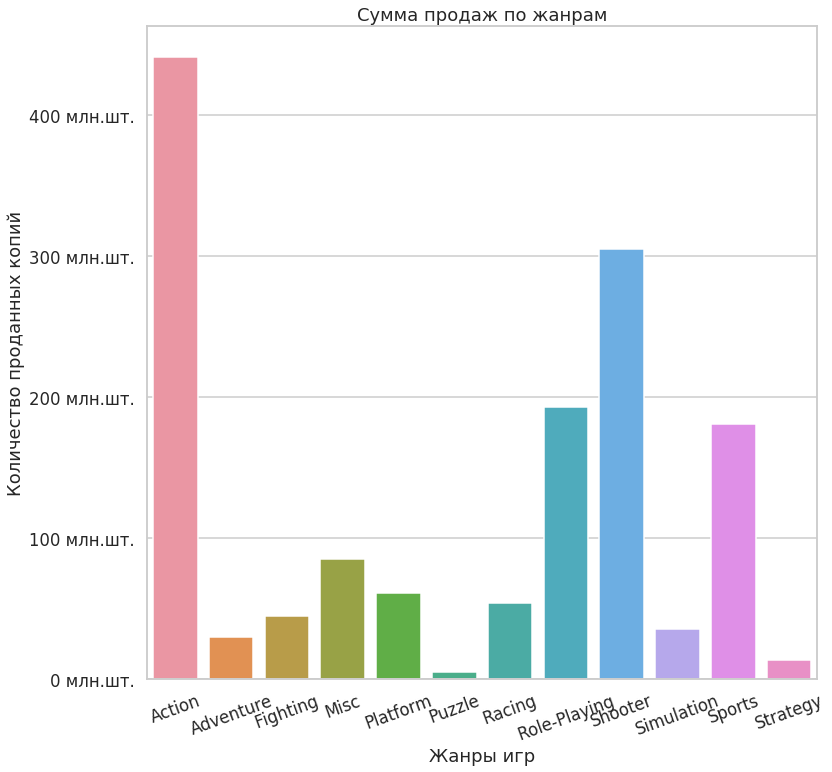

In [42]:
plt.figure(figsize=(12, 12))

ax = sns.barplot(
    x = 'genre',
    y = 'total_sales',
    data = actual_games,
    estimator=sum,
    ci=None
)

ylabels = ['{:.0f}'.format(x) + ' млн.шт.' for x in ax.get_yticks() / 1000]
ax.set_yticklabels(ylabels)
plt.title('Сумма продаж по жанрам')
plt.ylabel('Количество проданных копий')
plt.xlabel('Жанры игр')
plt.xticks(rotation=20)
plt.show()

По сумме продаж лидируют "экшен"-игры, а "шутеры" на втором месте. Видимо, среди первых есть очень успешные игры с огромным количеством продаж, которые выпадают из обычных игр в "ящике с усами". Ещё на такие результаты может влиять разное количество игр в разных жанрах.

**Вывод**
1. Наиболее перспективные платформы PS4 и XOne.
2. Игры с негативной оценкой критиков плохо продаются.
3. Лучше всего продаются игры в жанре "шутер", но суммарно продажи выше у "экшен".

### Вывод

Срок жизни игровых платформ составляет около 10 лет. Исключением является PC, популярность которого стала падать только недавно и совпала с появлением PS4. Новыми перспективными платформами, которые только набирают рост, можно считать PS4 и XOne. Стоит присмотреться к новой платформе Nintendo, когда она появится на рынке. На высокую популярность игр не влияют оценки пользователей и критиков, но игры, получившие низки оценки критиков, продаются плохо. Самым популярным жанром является "шутер", затем идут спортивные игры и "платформеры". При этом суммарные продажи выше у "экшен"-игр.

## Анализ пользователей по регионам

### Популярные платформы

Посмотрим, какие платформы более популярны в разных регионах.

In [43]:
def top5_per_regions (parameter):
    #Суммарные продажи в регионах
    sales_per_regions = actual_games.pivot_table(
        index= parameter, 
        values= ['na_sales','eu_sales','jp_sales','other_sales'],
        aggfunc= 'sum'
    )
    
    #Доля от общего числа продаж для каждого региона
    sales_per_regions['na_sales'] /= sales_per_regions['na_sales'].sum()
    sales_per_regions['eu_sales'] /= sales_per_regions['eu_sales'].sum()
    sales_per_regions['jp_sales'] /= sales_per_regions['jp_sales'].sum()
    sales_per_regions['other_sales'] /= sales_per_regions['other_sales'].sum()
    
    #Топ-5 и проценты продаж для каждого региона
    sales_na_percents = (
        sales_per_regions
        .sort_values(by='na_sales', ascending=False)['na_sales']
        .head(5).map('{:.1%}'.format)
        .reset_index()
    )
    sales_na_percents.set_axis(['na_top5','na_sales'], axis=1, inplace=True)

    sales_eu_percents = (
        sales_per_regions
        .sort_values(by='eu_sales', ascending=False)['eu_sales']
        .head(5).map('{:.1%}'.format)
        .reset_index()
    )
    sales_eu_percents.set_axis(['eu_top5','eu_sales'], axis=1, inplace=True)

    sales_jp_percents = (
        sales_per_regions
        .sort_values(by='jp_sales', ascending=False)['jp_sales']
        .head(5).map('{:.1%}'.format)
        .reset_index()
    )
    sales_jp_percents.set_axis(['jp_top5','jp_sales'], axis=1, inplace=True)

    sales_other_percents = (
        sales_per_regions
        .sort_values(by='other_sales', ascending=False)['other_sales']
        .head(5).map('{:.1%}'.format)
        .reset_index()
    )
    sales_other_percents.set_axis(['other_top5','other_sales'], axis=1, inplace=True)

    sales_percents = (
        sales_na_percents
        .join(sales_eu_percents)
        .join(sales_jp_percents)
        .join(sales_other_percents)
    )

    return sales_percents

print('Топ-5 платформ в каждом регионе и проценты продаж:')
top5_per_regions('platform')

Топ-5 платформ в каждом регионе и проценты продаж:


,na_top5,na_sales,eu_top5,eu_sales,jp_top5,jp_sales,other_top5,other_sales
0,X360,23.7%,PS4,27.8%,3DS,45.6%,PS4,31.0%
1,PS4,18.4%,PS3,21.1%,PS3,18.3%,PS3,27.7%
2,PS3,17.5%,X360,14.7%,PSV,10.9%,X360,13.1%
3,XOne,15.8%,XOne,10.2%,PS4,8.3%,XOne,9.1%
4,3DS,9.4%,3DS,8.4%,WiiU,6.8%,3DS,5.7%


В Европе и во всех остальных регионах, за исключением Северной Америки и Японии, лидируют продажи игр на  Play Station, причём PS4 популярнее PS3. Следом идут Xbox, и новая XOne уступает X360. Замыкает пятёрку платформа 3DS от Nintendo. В Северной Америке самой популярной платформой является X360, и уже за ней следуют PS4, PS3 и XOne. В Японии же наибольшей популярностью пользуется Nintendo.

**Вывод**

Платформа PS4 завоивала Европу и другие страны. В Северной Америке она на втором месте по популярности и в будущем может опередить устаревающую X360. Перспективная платформа XOne менее популярна и пока не может опередить по популярности ни X360, ни платформы от Play Station. Японский рынок отличается от общемирового, там лидирует Nintendo (45.6% у 3DS, 6.8% у WiiU), а PS4 - только четвёртая по популярности, и на неё приходится 8.3% всех продаж игр в Японии.

### Популярные жанры

Посмотрим, какие жанры популярны в разных регионах.

In [44]:
print('Топ-5 жанров в каждом регионе и проценты продаж:')
top5_per_regions('genre')

Топ-5 жанров в каждом регионе и проценты продаж:


,na_top5,na_sales,eu_top5,eu_sales,jp_top5,jp_sales,other_top5,other_sales
0,Action,30.1%,Action,31.4%,Role-Playing,34.0%,Action,32.7%
1,Shooter,24.5%,Shooter,22.4%,Action,27.4%,Shooter,23.9%
2,Sports,13.8%,Sports,13.6%,Misc,6.7%,Sports,14.4%
3,Role-Playing,10.8%,Role-Playing,9.6%,Simulation,5.4%,Role-Playing,9.5%
4,Misc,6.5%,Racing,5.4%,Fighting,4.9%,Misc,4.9%


Во всём мире, кроме Японии, лидируют "экшен"-игры, "шутеры" на втором месте, а спортивные игры - на третьем. В Японии же наиболее популярны RPG (видимо, японские), которые вытеснили "экшен" на второе место. При этом "шутеры" и спортивные игры в Японии не популярны. 

**Вывод**

Японский рынок отличается от общемирового. Если во всех остальных регионах в тройке лидиров находятся "экшен", "шутеры" и спортивные игры, то в Японии ролевые игры популярнее, чем "экшен", а "шутеры" и спортивные игры не популярны вообще.

### Влияние рейтинга ESRB на продажи

Посмотрим на зависимость продаж от рейтинга ESRB для каждого региона.

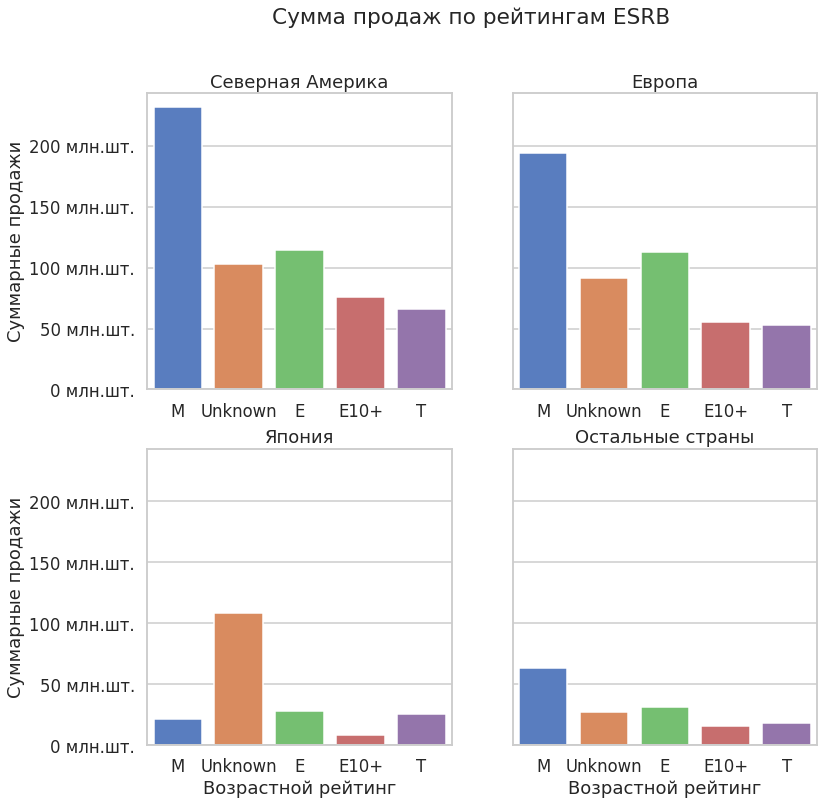

In [45]:
rating_values = actual_games['rating'].unique()

f, ax = plt.subplots(2, 2, sharey=True)
f.set_figheight(12)
f.set_figwidth(12)
f.suptitle('Сумма продаж по рейтингам ESRB')

sns.barplot(
    x = 'rating',
    y = 'na_sales',
    data = actual_games,
    order = rating_values,
    estimator=sum,
    ci=None,
    ax = ax[0,0]
)

sns.barplot(
    x = 'rating',
    y = 'eu_sales',
    data = actual_games,
    order = rating_values,
    estimator=sum,
    ci=None,
    ax = ax[0,1]
)

sns.barplot(
    x = 'rating',
    y = 'jp_sales',
    data = actual_games,
    order = rating_values,
    estimator=sum,
    ci=None,
    ax = ax[1,0]
)

sns.barplot(
    x = 'rating',
    y = 'other_sales',
    data = actual_games,
    order = rating_values,
    estimator=sum,
    ci=None,
    ax = ax[1,1]
)

ax[0, 0].set_title('Северная Америка')
ax[0, 1].set_title('Европа')
ax[1, 0].set_title('Япония')
ax[1, 1].set_title('Остальные страны')

for i in range(2):
    ylabels = ['{:.0f}'.format(x) + ' млн.шт.' for x in ax[i,0].get_yticks() / 1000]
    ax[i,0].set_yticklabels(ylabels)
        
ax[0, 0].set(xlabel='', ylabel='Cуммарные продажи')
ax[0, 1].set(xlabel='', ylabel='')
ax[1, 0].set(xlabel='Возрастной рейтинг', ylabel='Cуммарные продажи')
ax[1, 1].set(xlabel='Возрастной рейтинг', ylabel='')

plt.show()

Наибольшее количество продаж приходится на Северную Америку и Европу. Во всём мире, кроме Японии, лучше всего продаются игры для взрослых (Mature), а игры для подростков пользуются наименьшей популярностью. В Японии суммарные продажи не выделяют особой зависимости от возраста аудитории, разве что игры категории 10+ продаются хуже всех остальных. При этом на японском рынке лучше всего продаются игры, рейтинг которых в таблице не определён. Возможно, у таких игр нет рейтинга, потому что это внутреяпонские игры, а ESRB - американская система.

Но недостаточно посмотреть на суммы продаж, потому что некоторые очень популярные игры могут искажать картину. Рассмотрим медианные значения продаж игр в регионах.

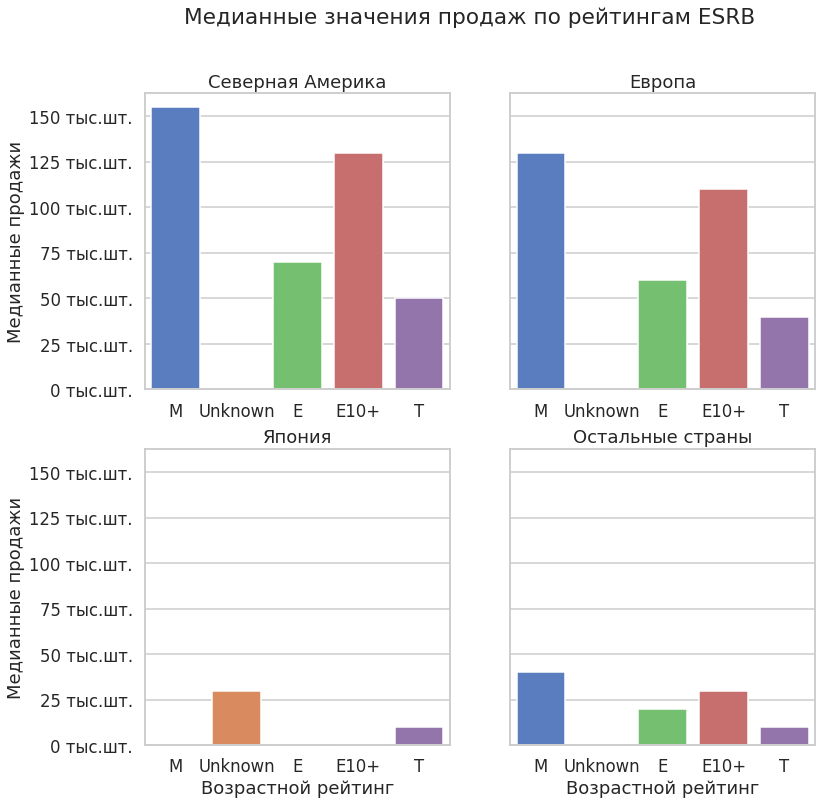

In [46]:
f, ax = plt.subplots(2, 2, sharey=True)
f.set_figheight(12)
f.set_figwidth(12)
f.suptitle('Медианные значения продаж по рейтингам ESRB')

sns.barplot(
    x = 'rating',
    y = 'na_sales',
    data = actual_games,
    order = rating_values,
    estimator=np.median,
    ci=None,
    ax = ax[0,0]
)

sns.barplot(
    x = 'rating',
    y = 'eu_sales',
    data = actual_games,
    order = rating_values,
    estimator=np.median,
    ci=None,
    ax = ax[0,1]
)

sns.barplot(
    x = 'rating',
    y = 'jp_sales',
    data = actual_games,
    order = rating_values,
    estimator=np.median,
    ci=None,
    ax = ax[1,0]
)

sns.barplot(
    x = 'rating',
    y = 'other_sales',
    data = actual_games,
    order = rating_values,
    estimator=np.median,
    ci=None,
    ax = ax[1,1]
)

ax[0, 0].set_title('Северная Америка')
ax[0, 1].set_title('Европа')
ax[1, 0].set_title('Япония')
ax[1, 1].set_title('Остальные страны')

for i in range(2):
    ylabels = ['{:.0f}'.format(x) + ' тыс.шт.' for x in ax[i,0].get_yticks()]
    ax[i,0].set_yticklabels(ylabels)
        
ax[0, 0].set(xlabel='', ylabel='Медианные продажи')
ax[0, 1].set(xlabel='', ylabel='')
ax[1, 0].set(xlabel='Возрастной рейтинг', ylabel='Медианные продажи')
ax[1, 1].set(xlabel='Возрастной рейтинг', ylabel='')

plt.show()

Во всём мире наибольшей популярностью пользуются игры для взрослых. Медианные значения продаж игр 10+ по миру тоже достаточно высоки. При этом в Японии хорошо продаются игры для подростков, но наиболее популярными там являются игры без рейтинга ESRB. 

**Вывод**

Больше всего игр продаётся в Северной Америке и Европе. Игры для взрослых продаются лучше всех, у игр 10+ тоже хорошие медианные продажи, но суммарно они проигрывают играм категории E (Everyone). В Японии другая картина: медианные продажи игр для подростков существенно превышают все остальные категории, а лучше всего там продаются игры, у которых категория не определена. Скорее всего, это непосредственно японские игры для внутреннего рынка.

### Вывод

Из всех регионов выделяется Япония: у них свои платформы, свои игры и свои игровые жанры. Во всём остальном мире лучше всего продаются игры для взрослых жанров "экшен", "шутер" и "спорт". Наибольшей популярностью пользуется платформа PS4, но в Северной Америке её опережает X360. В целом Xbox в Северной Америке занимает большую долю рынка, чем Play Station, а в Европе и других странах (кроме Японии) наоборот.

## Проверка гипотез

### Сравнение рейтингов Xbox One и PC

Одни и те же игры выходят на разных платформах, но будут ли оценки пользователей одинаковыми для этих платформ? В разделе 3.3 мы отказались от идеи заполнять пропущенные значения оценок по оценкам тех же игр на других платформах, исходя из предположения, что оценки могут быть разными. Проверим эту гипотезу на примере Xbox One и PC. Xbox One - набирающая популярность новая консоль, а персональный компьютер - долго существующий на рынке альтернативный вариант игровой платформы.

Чтобы проверить, что оценки отличаются, сформулируем нулевую гипотезу H<sub>0</sub>: "Средние оценки пользователей игр на Xbox One и PC одинаковые". Если эта гипотеза окажется опровергнутой, то можно будет считать верной альтернативную гипотезу H<sub>1</sub>: "Средние оценки пользователей игр на Xbox One и PC отличаются".

Чтобы проверить H<sub>0</sub>, посчитаем вероятность получить из генеральной совокупности игр такую выборку, которая у нас есть, исходя из предположения, что гипотеза H<sub>0</sub> верна. Если получившаяся вероятность будет меньше порогового значения alpha, то гипотеза будет опровергнута. Это будет означать, что из генеральной совокупности нельзя было бы выделить нашу выборку. Если вероятность окажется выше alpha, то сделать какой-то вывод о гипотезе будет нельзя. Т.к. выборка достаточно большая, то установим пороговое значение alpha=1%. 

Можно предположить, что дисперсии генеральных совокупностей оценок пользователей Xbox One и PC одинаковые: люди одинаково строго судят игры на любых платформах - поэтому установим equal_var=True.

In [47]:
alpha = 0.01
p_value = st.ttest_ind(actual_games[(actual_games['platform'] == 'XOne') & (actual_games['user_score'].notna())]['user_score'],
                       actual_games[(actual_games['platform'] == 'PC') & (actual_games['user_score'].notna())]['user_score'],
                       equal_var=True
                      ).pvalue

if p_value < alpha:
    print('Нулевая гипотеза опровергнута.')
    print('Средние оценки пользователей игр на Xbox One и PC отличаются.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.') 
    print('p-value = {:.2%}'.format(p_value))

Не получилось отвергнуть нулевую гипотезу.
p-value = 55.35%


**Вывод**

Оказалось, что нельзя точно сказать что-то о различиях в оценках пользователей игр на Xbox One и PC. Выборка не противоречит предположению, что оценки одинаковые.

### Сравнение рейтингов жанров Action и Sports

Аналогично проверим, отличаются ли оценки игр разных жанров на примере популярных Action и Sports. Для выборки по-прежнему будем считать пороговое значение alpha=1%. А вот дисперсии у разных жанров могут отличаться, поэтому примем equal_var=False.

Нулевая гипотеза H<sub>0</sub>: "Средние оценки пользователей игр в жанрах "экшен" и "спорт" одинаковые". 

Альтернативная гипотеза H<sub>1</sub>: "Средние оценки пользователей игр в жанрах "экшен" и "спорт" отличаются".

In [48]:
alpha = 0.01
p_value = st.ttest_ind(actual_games[(actual_games['genre'] == 'Action') & (actual_games['user_score'].notna())]['user_score'],
                       actual_games[(actual_games['genre'] == 'Sports') & (actual_games['user_score'].notna())]['user_score'],
                       equal_var=False
                      ).pvalue

if p_value < alpha:
    print('Нулевая гипотеза опровергнута.')
    print('Средние оценки пользователей игр в жанрах "экшен" и "спорт" отличаются.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.') 
    print('p-value = {:.2%}'.format(p_value))

Нулевая гипотеза опровергнута.
Средние оценки пользователей игр в жанрах "экшен" и "спорт" отличаются.


**Вывод**

Проведённый t-тест показал, что оценки пользователей игр в жанрах "экшен" и "спорт" отличаются. Для теста мы считали дисперсии выборок разными, а пороговое значение alpha=1%.

### Вывод

После проведённых t-тестов можно сказать:
1. Выборка не противоречит предположению, что средние оценки пользователей игр на Xbox One и PC одинаковые.
2. Средние оценки пользователей игр в жанрах "экшен" и "спорт" отличаются.

Пороговое значение alpha было выбрано 1%. Для проверки первой гипотезы дисперсии считались одинаковыми, а для проверки второй - различными.

## Общий вывод

В работе проанализированы данные об играх, их оценках и количестве проданных копий в разных регионах. Таблица была подготовлена: числовые значения пересчитаны в другой масштаб измерения, оценки "tbd" убраны, типы данных преобразованы, добавлен столбец с суммарными продажами по миру. 

Из общего количества информации был выделен срез актуальных данных за 5 лет: с 2012 по 2016. Перспективными платформами являются Xbox One и Play Station 4. Самые высокие медианные продажи у "шутеров", а суммарные - у "экшен"-игр. Высокие оценки критиков не гарантируют хорошие продажи, но низкие оценки означают, что игра будет продаваться плохо. Оценки пользователей не коррелируют с продажами. 

Японский рынок отличается от всего остального мира: там популярны платформы Nintendo, игры жанра RPG и непосредственно японские игры. В других странах наибольшую прибыль приносят взрослые игры жанров "экшен", "шутер" и "спорт", а среди платформ лидируют Xbox и Play Station. Причём в Северной Америке популярнее Xbox, а в Европе и других странах (кроме Японии) - Play Station. Больше всего игр продаётся в Северной Америке и Европе.

Проверка статистических гипотез показала, что средние оценки пользователей игр в жанрах "экшен" и "спорт" отличаются, а сделать вывод о различиях оценок игр на Xbox One и PC не представляется возможным: нулевая гипотеза не опровергнута.

Если ориентироваться на европейский рынок, нужно делать ставку на игры для взрослых жанров "экшен", "шутер" и "спорт", выпущенных на PS4 и с хорошими оценками критиков.

Для американского рынка актуальнее делать ставку на Xbox, для Японии - на 3DS.

"Шутеры" показывают стабильно высокие продажи, но на японском рынке они не популярны. 